## Prep/loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter
from sklearn.preprocessing import StandardScaler
import os, sys
parent_dir = os.path.abspath('../../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from functions.back_transformations import inverse_scale_variable, predict_with_back_transform

Get regression results objects

In [2]:
%store -r bivariate_regressions_balanced
%store -r bivariate_regressions_unbalanced
%store -r bivariate_regressions_balanced_accounts
%store -r bivariate_regressions_unbalanced_accounts
%store -r bivariate_regressions_balanced_exiobase
%store -r bivariate_regressions_unbalanced_exiobase
%store -r bivariate_regressions_balanced_accounts_exiobase
%store -r bivariate_regressions_unbalanced_accounts_exiobase

%store -r single_regressions_balanced
%store -r single_regressions_unbalanced
%store -r single_regressions_balanced_accounts
%store -r single_regressions_unbalanced_accounts
%store -r single_regressions_balanced_exiobase
%store -r single_regressions_unbalanced_exiobase
%store -r single_regressions_balanced_accounts_exiobase
%store -r single_regressions_unbalanced_accounts_exiobase

%store -r multiple_regressions_balanced
%store -r multiple_regressions_unbalanced
%store -r multiple_regressions_balanced_accounts
%store -r multiple_regressions_unbalanced_accounts
%store -r multiple_regressions_balanced_exiobase
%store -r multiple_regressions_unbalanced_exiobase
%store -r multiple_regressions_balanced_accounts_exiobase
%store -r multiple_regressions_unbalanced_accounts_exiobase

Here's an example of what info each object has, `data` contains the data used to fit the regression in a data frame, model is the `model` object

In [3]:
bivariate_regressions_balanced[0].keys()

dict_keys(['model', 'name', 'data', 'dependent_variable', 'independent_variables', 'goodness_of_fit'])

In [4]:
foundational_df_no_transformations = pd.read_csv('./output/foundational_no_transformations.csv')
foundational_df_transformed = pd.read_csv('./output/foundational_transformed.csv')
foundational_df_no_transformations_accounts = pd.read_csv('./output/foundational_no_transformations_accounts.csv')
foundational_df_transformed_accounts = pd.read_csv('./output/foundational_transformed_accounts.csv')

In [5]:
# foundational_df_no_transformations_exiobase = pd.read_csv('./output/foundational_df_no_transformations_exiobase_no_outliers.csv')
foundational_df_transformed_exiobase = pd.read_csv('./output/foundational_df_transformed_no_outliers_exiobase.csv')
# foundational_df_no_transformations_accounts_exiobase = pd.read_csv('./output/foundational_df_no_transformations_accounts_exiobase_no_outliers.csv')
foundational_df_transformed_accounts_exiobase = pd.read_csv('./output/foundational_df_transformed_no_outliers_accounts_exiobase.csv')
foundational_df_no_transformations_no_outliers_exiobase = pd.read_csv('./output/foundational_df_no_transformations_no_outliers_exiobase.csv')
foundational_df_no_transformations_no_outliers_accounts_exiobase = pd.read_csv('./output/foundational_df_no_transformations_no_outliers_accounts_exiobase.csv')

Values from StandardScaler used to transform the data. We'll need them for the back transformation.

In [6]:
# as a data frame
scaler_df = pd.read_csv('./output/scaler_values.csv')
scaler_df_accounts = pd.read_csv('./output/scaler_values_accounts.csv')
scaler_df_exiobase = pd.read_csv('./output/scaler_values_exiobase.csv')
scaler_df_accounts_exiobase = pd.read_csv('./output/scaler_values_accounts_exiobase.csv')

In [7]:
# original scaler object used to scale the values
%store -r scaler
%store -r scaler_exiobase

## Comparing goodness of fit

Print our goodness of fit measures. Two rows for each type of regression since I did them with two different methods. 

The second value for each regression is likely more reliable, since I used an [existing panel analysis library](https://github.com/bashtage/linearmodels) for this one. The disadvantage is that it didn't calculate an AIC (shown as NaN), need to do this manually.

Labour cost survey data

In [8]:
all_regressions = bivariate_regressions_balanced + single_regressions_balanced + multiple_regressions_balanced
df_regressions = pd.DataFrame(all_regressions)

In [208]:
all_regressions_accounts = bivariate_regressions_accounts + single_regressions_accounts + multiple_regressions_accounts
df_regressions_accounts = pd.DataFrame(all_regressions_accounts)
# goodness_of_fit_df_accounts = pd.json_normalize(df_regressions_accounts['goodness_of_fit'])
# goodness_of_fit_df_accounts.head(15)

In [209]:
all_regressions_exiobase = bivariate_regressions_exiobase + single_regressions_exiobase + multiple_regressions_exiobase
df_regressions_exiobase = pd.DataFrame(all_regressions_exiobase)

In [210]:
all_regressions_accounts_exiobase = bivariate_regressions_accounts_exiobase + single_regressions_accounts_exiobase + multiple_regressions_accounts_exiobase
df_regressions_accounts_exiobase = pd.DataFrame(all_regressions_accounts_exiobase)

Which bivariate regressions have the best $R^2$?

In [9]:
bivariate_regressions_df = df_regressions[df_regressions['name'].str.contains('Bivariate')]
bivariate_regressions_df = bivariate_regressions_df.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
bivariate_regressions_df_overview = bivariate_regressions_df[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
bivariate_regressions_df_overview = pd.concat([bivariate_regressions_df_overview.drop(['goodness_of_fit'], axis=1), bivariate_regressions_df_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
bivariate_regressions_df_overview = pd.concat([bivariate_regressions_df_overview.drop(['coefs'], axis=1), bivariate_regressions_df_overview['coefs'].apply(pd.Series)], axis=1)
bivariate_regressions_df_overview = bivariate_regressions_df_overview.loc[:,~bivariate_regressions_df_overview.columns.str.contains('T.True')]
bivariate_regressions_df_overview = bivariate_regressions_df_overview.drop(['model_name'], axis=1)
bivariate_regressions_df_overview

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC,const,energy
3,Pooled Ols Bivariate balanced,education,education,0.390974,-90.833473,None,-0.086468,-0.881192
5,Random Effects Bivariate balanced,education,education,0.345208,-48.030938,None,-0.091442,-0.589876
6,Pooled Ols Bivariate balanced,socialsupport,socialsupport,0.250376,-86.599056,None,-0.094384,-0.611803
8,Random Effects Bivariate balanced,socialsupport,socialsupport,0.250361,-68.336085,None,-0.094307,-0.616335
0,Pooled Ols Bivariate balanced,hale,hale,0.216527,-96.544240,None,0.027744,-0.640373
4,Fixed Effects Bivariate balanced,education,education,0.107981,-24.747190,None,-0.122721,1.242034
2,Random Effects Bivariate balanced,hale,hale,0.098473,-17.283542,None,0.020144,-0.195221
1,Fixed Effects Bivariate balanced,hale,hale,0.063818,2.979536,None,0.005062,0.688082
7,Fixed Effects Bivariate balanced,socialsupport,socialsupport,-0.003069,-53.886563,None,-0.092248,-0.736931


Don't trust the fixed effects result, it seems to have the best r squared but it's likely biased (maybe was wrongly calculated).
I think the Pooled OLS model has a better R squared because a model with only energy does not (cannot?) predict historical variation well? Then a simple pooled OLS will show a better fit

In [212]:
selected_bivariate_model_hale = bivariate_regressions_df.iloc[9]['model']
selected_bivariate_model_education = bivariate_regressions_df.iloc[0]['model']
selected_bivariate_model_socialsupport = bivariate_regressions_df.iloc[2]['model']

Same for Exiobase data

In [213]:
bivariate_regressions_df_exiobase = df_regressions_exiobase[df_regressions_exiobase['name'].str.contains('Bivariate')]
bivariate_regressions_df_exiobase = bivariate_regressions_df_exiobase.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
bivariate_regressions_df_overview_exiobase = bivariate_regressions_df_exiobase[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
bivariate_regressions_df_overview_exiobase = pd.concat([bivariate_regressions_df_overview_exiobase.drop(['goodness_of_fit'], axis=1), bivariate_regressions_df_overview_exiobase['goodness_of_fit'].apply(pd.Series)], axis=1)
bivariate_regressions_df_overview_exiobase = pd.concat([bivariate_regressions_df_overview_exiobase.drop(['coefs'], axis=1), bivariate_regressions_df_overview_exiobase['coefs'].apply(pd.Series)], axis=1)
bivariate_regressions_df_overview_exiobase = bivariate_regressions_df_overview_exiobase.loc[:,~bivariate_regressions_df_overview_exiobase.columns.str.contains('T.True')]
bivariate_regressions_df_overview_exiobase = bivariate_regressions_df_overview_exiobase.drop(['model_name'], axis=1)
bivariate_regressions_df_overview_exiobase

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC,const,energy,Intercept
13,Pooled OLS Bivariate linearmodels,socialsupport,[energy],0.286844,-95.765980,NaN,-0.151053,-0.629238,NaN
17,Random Effects Bivariate linearmodels,socialsupport,[energy],0.283632,-72.433159,NaN,-0.117481,-0.571530,NaN
12,Pooled OLS Bivariate,socialsupport,[energy],0.276700,-83.648986,171.297972,-0.085619,-0.604353,NaN
6,Pooled OLS Bivariate,education,[energy],0.214573,-93.863089,191.726177,-0.185946,-0.596571,NaN
16,Random Effects Bivariate,socialsupport,[energy],0.184965,-66.356926,136.713853,-0.046428,-0.561845,NaN
7,Pooled OLS Bivariate linearmodels,education,[energy],0.158240,-108.932668,NaN,-0.181186,-0.523970,NaN
11,Random Effects Bivariate linearmodels,education,[energy],0.052830,-49.144570,NaN,-0.119312,-0.127854,NaN
0,Pooled OLS Bivariate,hale,[energy],0.039508,-98.928385,201.856770,-0.086225,-0.282744,NaN
1,Pooled OLS Bivariate linearmodels,hale,[energy],0.038628,-111.874060,NaN,-0.093504,-0.301219,NaN
10,Random Effects Bivariate,education,[energy],0.022757,-47.874242,99.748485,-0.037163,-0.254882,NaN


In [214]:
selected_bivariate_model_exiobase_hale = bivariate_regressions_df_exiobase.iloc[8]['model']
selected_bivariate_model_exiobase_education = bivariate_regressions_df_exiobase.iloc[5]['model']
selected_bivariate_model_exiobase_socialsupport = bivariate_regressions_df_exiobase.iloc[1]['model']

In [215]:
selected_bivariate_model_exiobase_education.summary

Dep. Variable:,education,R-squared:,0.1796
Estimator:,PooledOLS,R-squared (Between):,0.1713
No. Observations:,80,R-squared (Within):,-0.2615
Date:,"Sat, Feb 24 2024",R-squared (Overall):,0.1796
Time:,19:34:42,Log-likelihood,-108.93
Cov. Estimator:,Clustered,,
,,F-statistic:,17.070
Entities:,28,P-value,0.0001
Avg Obs:,2.8571,Distribution:,"F(1,78)"
Min Obs:,1.0000,,
Max Obs:,3.0000,F-statistic (robust):,8.8599


In [216]:
bivariate_regressions_df_accounts = df_regressions_accounts[df_regressions_accounts['name'].str.contains('Bivariate')]
bivariate_regressions_df_accounts = bivariate_regressions_df_accounts.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
bivariate_regressions_df_accounts_overview = bivariate_regressions_df_accounts[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
bivariate_regressions_df_accounts_overview = pd.concat([bivariate_regressions_df_accounts_overview.drop(['goodness_of_fit'], axis=1), bivariate_regressions_df_accounts_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
bivariate_regressions_df_accounts_overview.head(15)

,name,dependent_variable,independent_variables,model_name,adj_r_squared,log_likelihood,AIC,coefs,0
7,Pooled OLS Bivariate Accounts,education,[energy],Pooled OLS Bivariate,0.389402,-321.678461,647.356922,const -0.080951 energy -0.752731 dtype: f...,NaN
14,Pooled OLS Bivariate Accounts,socialsupport,[energy],Pooled OLS Bivariate,0.356294,-341.382127,686.764253,const 0.023167 energy -0.753873 dtype: f...,NaN
19,Random Effects Bivariate Accounts linearmodels,socialsupport,[energy],Random Effects Bivariate,0.288590,-242.001931,NaN,const -0.046360 energy -0.845057 Name: pa...,NaN
10,Fixed Effects Bivariate linearmodels Accounts ...,education,[energy],Fixed Effects Bivariate,0.182649,-169.125669,NaN,const 0.090152 energy 1.477054 Name: pa...,NaN
0,Pooled OLS Bivariate Accounts,hale,[energy],Pooled OLS Bivariate,0.133744,-360.225169,724.450338,const 0.013695 energy -0.430108 dtype: f...,NaN
18,Random Effects Bivariate Accounts,socialsupport,[energy],Random Effects Bivariate,0.115559,-215.422969,434.845938,energy -0.839673 const 0.003928 dtype: f...,NaN
9,Fixed Effects Bivariate Accounts,education,[energy],Fixed Effects Bivariate,0.111078,-148.875110,345.750220,Intercept -4.351872e-16 BE[T.True] 5.167...,NaN
3,Fixed Effects Bivariate linearmodels Accounts ...,hale,[energy],Fixed Effects Bivariate,0.106225,-28.144844,NaN,const 0.104309 energy 0.694934 Name: pa...,NaN
17,Fixed Effects Bivariate linearmodels Accounts ...,socialsupport,[energy],Fixed Effects Bivariate,0.082447,-228.326421,NaN,const -0.071939 energy -1.154858 Name: pa...,NaN
4,Random Effects Bivariate Accounts,hale,[energy],Random Effects Bivariate,0.034947,-43.449914,90.899829,energy 0.375734 const 0.006912 dtype: f...,NaN


In [217]:
selected_bivariate_model_hale_accounts = bivariate_regressions_df_accounts.iloc[4]['model']
selected_bivariate_model_education_accounts = bivariate_regressions_df_accounts.iloc[0]['model']
selected_bivariate_model_socialsupport_accounts = bivariate_regressions_df_accounts.iloc[2]['model']
print(selected_bivariate_model_hale_accounts.summary())

                            OLS Regression Results                            
Dep. Variable:                   hale   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     43.15
Date:                Sun, 25 Feb 2024   Prob (F-statistic):           2.57e-10
Time:                        16:13:47   Log-Likelihood:                -360.23
No. Observations:                 274   AIC:                             724.5
Df Residuals:                     272   BIC:                             731.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0137      0.055      0.250      0.8

In [218]:
bivariate_regressions_df_accounts_exiobase = df_regressions_accounts_exiobase[df_regressions_accounts_exiobase['name'].str.contains('Bivariate')]
bivariate_regressions_df_accounts_exiobase = bivariate_regressions_df_accounts_exiobase.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
bivariate_regressions_df_accounts_overview_exiobase = bivariate_regressions_df_accounts_exiobase[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
bivariate_regressions_df_accounts_overview_exiobase = pd.concat([bivariate_regressions_df_accounts_overview_exiobase.drop(['goodness_of_fit'], axis=1), bivariate_regressions_df_accounts_overview_exiobase['goodness_of_fit'].apply(pd.Series)], axis=1)
bivariate_regressions_df_accounts_overview_exiobase

,name,dependent_variable,independent_variables,model_name,adj_r_squared,log_likelihood,AIC,coefs,0
12,Pooled OLS Bivariate Accounts,socialsupport,[energy],Pooled OLS Bivariate,0.290002,-354.810756,713.621513,const 0.020558 energy -0.717381 dtype: f...,NaN
17,Random Effects Bivariate Accounts linearmodels,socialsupport,[energy],Random Effects Bivariate,0.224727,-253.056567,NaN,const 0.010908 energy -0.392997 Name: pa...,NaN
4,Random Effects Bivariate Accounts,hale,[energy],Random Effects Bivariate,0.201951,-13.969114,31.938229,energy 0.429732 const 0.006474 dtype: f...,NaN
3,Fixed Effects Bivariate linearmodels Accounts ...,hale,[energy],Fixed Effects Bivariate,0.200871,-10.627478,NaN,const 0.070901 energy 0.407494 Name: pa...,NaN
6,Pooled OLS Bivariate Accounts,education,[energy],Pooled OLS Bivariate,0.182173,-361.711378,727.422757,const -0.069592 energy -0.545293 dtype: f...,NaN
2,Fixed Effects Bivariate Accounts,hale,[energy],Fixed Effects Bivariate,0.170559,1.978923,44.042153,Intercept -1.191991e-15 BE[T.True] 1.205...,NaN
9,Fixed Effects Bivariate linearmodels Accounts ...,education,[energy],Fixed Effects Bivariate,0.094356,-185.179057,NaN,const -0.000087 energy 0.466195 Name: pa...,NaN
10,Random Effects Bivariate Accounts,education,[energy],Random Effects Bivariate,0.051092,-183.172231,370.344462,energy 0.354561 const 0.000655 dtype: f...,NaN
16,Random Effects Bivariate Accounts,socialsupport,[energy],Random Effects Bivariate,0.044742,-224.643853,453.287706,energy -0.365466 const 0.011127 dtype: f...,NaN
8,Fixed Effects Bivariate Accounts,education,[energy],Fixed Effects Bivariate,0.040118,-159.396835,366.793670,Intercept -8.485952e-16 BE[T.True] 1.089...,NaN


In [219]:
selected_bivariate_model_hale_exiobase_accounts = bivariate_regressions_df_accounts_exiobase.iloc[2]['model']
selected_bivariate_model_education_exiobase_accounts = bivariate_regressions_df_accounts_exiobase.iloc[4]['model']
selected_bivariate_model_socialsupport_exiobase_accounts = bivariate_regressions_df_accounts_exiobase.iloc[1]['model']

Which single regressions have the best $R^2$?

In [220]:
single_regressions_df = df_regressions[df_regressions['name'].str.contains('Single')]
single_regressions_df = single_regressions_df.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
single_regressions_df_overview = single_regressions_df[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
single_regressions_df_overview = pd.concat([single_regressions_df_overview.drop(['goodness_of_fit'], axis=1), single_regressions_df_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
single_regressions_df_overview = pd.concat([single_regressions_df_overview.drop(['coefs'], axis=1), single_regressions_df_overview['coefs'].apply(pd.Series)], axis=1)
single_regressions_df_overview = single_regressions_df_overview.loc[:,~single_regressions_df_overview.columns.str.contains('T.True')]
single_regressions_df_overview = single_regressions_df_overview.drop(['model_name'], axis=1)
single_regressions_df_overview

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC,const,energy,material,energy:material,other,energy:other,overlooked,energy:overlooked,providential,energy:providential,Intercept
24,Pooled OLS Single,hale,"[energy, material]",0.689945,-58.873866,125.747732,-0.079790,-0.238630,0.751682,-0.387424,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Pooled OLS Single linearmodels,hale,"[energy, material]",0.613360,-74.386643,NaN,-0.055347,-0.309061,0.682428,-0.350512,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,Random Effects Single linearmodels,hale,"[energy, material]",0.569230,-8.742890,NaN,-0.015082,-0.132578,0.559063,-0.297163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,Pooled OLS Single,education,"[energy, material]",0.502155,-77.087676,162.175351,-0.121125,-0.682669,0.404427,-0.093638,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,Pooled OLS Single linearmodels,education,"[energy, material]",0.493794,-87.537890,NaN,-0.124543,-0.669247,0.442617,-0.133071,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,Fixed Effects Single,socialsupport,"[energy, material]",-0.403524,-45.040975,144.081951,NaN,-0.983759,1.089223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.956926e-16
32,Fixed Effects Single,hale,"[energy, providential]",-0.420635,9.454494,35.091012,NaN,0.796025,NaN,NaN,NaN,NaN,NaN,NaN,0.271733,NaN,-3.140076e-16
26,Fixed Effects Single,hale,"[energy, material]",-0.427103,9.297786,35.404428,NaN,0.635395,0.241177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.288628e-16
68,Fixed Effects Single,socialsupport,"[energy, overlooked]",-0.477150,-46.804921,147.609843,NaN,-0.933567,NaN,NaN,NaN,NaN,0.708703,NaN,NaN,NaN,4.407756e-17


Pick some interesting models from the table

In [221]:
selected_single_model_hale_material = single_regressions_df.iloc[2]['model']
selected_single_model_hale_providential = single_regressions_df.iloc[48]['model']
selected_single_model_hale_overlooked = single_regressions_df.iloc[45]['model']
selected_single_model_hale_other = single_regressions_df.iloc[34]['model']
selected_single_model_education_material = single_regressions_df.iloc[7]['model']
selected_single_model_education_providential = single_regressions_df.iloc[21]['model']
selected_single_model_education_overlooked = single_regressions_df.iloc[6]['model']
selected_single_model_education_other = single_regressions_df.iloc[10]['model']
selected_single_model_socialsupport_material = single_regressions_df.iloc[24]['model']
selected_single_model_socialsupport_providential = single_regressions_df.iloc[31]['model']
selected_single_model_socialsupport_overlooked = single_regressions_df.iloc[16]['model']
selected_single_model_socialsupport_other = single_regressions_df.iloc[13]['model']

In [222]:
single_regressions_df_exiobase = df_regressions_exiobase[df_regressions_exiobase['name'].str.contains('Single')]
single_regressions_df_exiobase = single_regressions_df_exiobase.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
single_regressions_df_overview_exiobase = single_regressions_df_exiobase[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
single_regressions_df_overview_exiobase = pd.concat([single_regressions_df_overview_exiobase.drop(['goodness_of_fit'], axis=1), single_regressions_df_overview_exiobase['goodness_of_fit'].apply(pd.Series)], axis=1)
single_regressions_df_overview_exiobase = pd.concat([single_regressions_df_overview_exiobase.drop(['coefs'], axis=1), single_regressions_df_overview_exiobase['coefs'].apply(pd.Series)], axis=1)
single_regressions_df_overview_exiobase = single_regressions_df_overview_exiobase.loc[:,~single_regressions_df_overview_exiobase.columns.str.contains('T.True')]
single_regressions_df_overview_exiobase = single_regressions_df_overview_exiobase.drop(['model_name'], axis=1)
single_regressions_df_overview_exiobase.head(35)

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC,const,energy,material,energy:material,overlooked,energy:overlooked,providential,energy:providential,other,energy:other,Intercept
24,Pooled OLS Single EXIOBASE,hale,"[energy, material]",0.665889,-61.451820,130.903640,-0.037466,-0.106004,0.802274,-0.353281,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Pooled OLS Single linearmodels EXIOBASE,hale,"[energy, material]",0.573578,-78.304024,NaN,-0.037716,-0.202679,0.720645,-0.289480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,Random Effects Single linearmodels EXIOBASE,hale,"[energy, material]",0.506562,-14.035107,NaN,-0.007695,-0.117561,0.606933,-0.081505,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,Pooled OLS Single linearmodels EXIOBASE,socialsupport,"[energy, overlooked]",0.398139,-87.926339,NaN,-0.140574,-0.556753,NaN,NaN,0.233947,-0.433790,NaN,NaN,NaN,NaN,NaN
48,Pooled OLS Single EXIOBASE,education,"[energy, material]",0.398115,-83.634991,175.269982,-0.151965,-0.507792,0.492005,-0.119480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,Random Effects Single linearmodels EXIOBASE,socialsupport,"[energy, overlooked]",0.394601,-70.737956,NaN,-0.096275,-0.509916,NaN,NaN,0.298953,-0.369926,NaN,NaN,NaN,NaN,NaN
66,Pooled OLS Single EXIOBASE,socialsupport,"[energy, overlooked]",0.379428,-77.318699,162.637398,-0.090310,-0.533430,NaN,NaN,0.225703,-0.416437,NaN,NaN,NaN,NaN,NaN
49,Pooled OLS Single linearmodels EXIOBASE,education,"[energy, material]",0.379344,-95.691239,NaN,-0.141930,-0.463326,0.504963,-0.154264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,Pooled OLS Single EXIOBASE,education,"[energy, overlooked]",0.375465,-84.909458,177.818915,0.086865,-0.403264,NaN,NaN,0.646293,0.479784,NaN,NaN,NaN,NaN,NaN
28,Random Effects Single EXIOBASE,hale,"[energy, material]",0.358450,-17.521834,41.043668,-0.002136,-0.079760,0.706989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [223]:
selected_single_model_exiobase_hale_material = single_regressions_df_exiobase.iloc[2]['model']
selected_single_model_exiobase_education_providential = single_regressions_df_exiobase.iloc[10]['model']
selected_single_model_exiobase_socialsupport_overlooked = single_regressions_df_exiobase.iloc[5]['model']

In [224]:
single_regressions_df_accounts = df_regressions_accounts[df_regressions_accounts['name'].str.contains('Single')]
single_regressions_df_accounts = single_regressions_df_accounts.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
single_regressions_df_accounts_overview = single_regressions_df_accounts[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
single_regressions_df_accounts_overview = pd.concat([single_regressions_df_accounts_overview.drop(['goodness_of_fit'], axis=1), single_regressions_df_accounts_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
single_regressions_df_accounts_overview = pd.concat([single_regressions_df_accounts_overview.drop(['coefs'], axis=1), single_regressions_df_accounts_overview['coefs'].apply(pd.Series)], axis=1)
single_regressions_df_accounts_overview = single_regressions_df_accounts_overview.loc[:,~single_regressions_df_accounts_overview.columns.str.contains('T.True')]
single_regressions_df_accounts_overview = single_regressions_df_accounts_overview.drop(['model_name'], axis=1)
single_regressions_df_accounts_overview

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC,const,energy,material,energy:material,other,energy:other,providential,energy:providential,overlooked,energy:overlooked,Intercept,Group Var
84,Pooled OLS Single Accounts,socialsupport,"[energy, material]",0.501783,-305.270627,618.541254,-0.020763,-0.813465,0.107183,-0.591127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,Pooled OLS Single linearmodels Accounts,socialsupport,"[energy, material]",0.470217,-351.504150,NaN,-0.065498,-0.800339,0.108082,-0.590456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,Pooled OLS Single Accounts,education,"[energy, other]",0.435714,-309.860984,627.721969,-0.077958,-0.813242,NaN,NaN,0.095534,0.350277,NaN,NaN,NaN,NaN,NaN,NaN
63,Pooled OLS Single Accounts,education,"[energy, providential]",0.426473,-312.086542,632.173084,-0.046223,-0.741837,NaN,NaN,NaN,NaN,-0.094873,-0.256589,NaN,NaN,NaN,NaN
49,Pooled OLS Single Accounts,education,"[energy, overlooked]",0.423046,-312.902599,633.805198,-0.056166,-0.732933,NaN,NaN,NaN,NaN,NaN,NaN,0.155076,0.333759,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Mixed Effects Single Accounts,education,"[energy, other]",NaN,-227.073438,NaN,0.061944,1.128136,NaN,NaN,0.155638,0.243433,NaN,NaN,NaN,NaN,NaN,17.057773
83,Mixed Effects Single Accounts,socialsupport,"[energy, overlooked]",NaN,-255.097256,NaN,-0.018237,-0.810038,NaN,NaN,NaN,NaN,NaN,NaN,0.122716,0.034912,NaN,1.909561
90,Mixed Effects Single Accounts,socialsupport,"[energy, material]",NaN,-253.532523,NaN,-0.030983,-0.820675,0.061841,-0.256179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.349304
97,Mixed Effects Single Accounts,socialsupport,"[energy, providential]",NaN,-255.961595,NaN,-0.035334,-0.806298,NaN,NaN,NaN,NaN,0.003232,0.079381,NaN,NaN,NaN,1.841954


In [225]:
selected_single_model_hale_material_accounts = single_regressions_df_accounts.iloc[25]['model']
selected_single_model_hale_providential_accounts = single_regressions_df_accounts.iloc[22]['model']
selected_single_model_hale_overlooked_accounts = single_regressions_df_accounts.iloc[27]['model']
selected_single_model_hale_other_accounts = single_regressions_df_accounts.iloc[14]['model']
selected_single_model_education_material_accounts = single_regressions_df_accounts.iloc[9]['model']
selected_single_model_education_providential_accounts = single_regressions_df_accounts.iloc[3]['model']
selected_single_model_education_overlooked_accounts = single_regressions_df_accounts.iloc[4]['model']
selected_single_model_education_other_accounts = single_regressions_df_accounts.iloc[2]['model']
selected_single_model_socialsupport_material_accounts = single_regressions_df_accounts.iloc[6]['model']
selected_single_model_socialsupport_providential_accounts = single_regressions_df_accounts.iloc[19]['model']
selected_single_model_socialsupport_overlooked_accounts = single_regressions_df_accounts.iloc[21]['model']
selected_single_model_socialsupport_other_accounts = single_regressions_df_accounts.iloc[20]['model']

In [226]:
single_regressions_df_accounts_exiobase = df_regressions_accounts_exiobase[df_regressions_accounts_exiobase['name'].str.contains('Single')]
single_regressions_df_accounts_exiobase = single_regressions_df_accounts_exiobase.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
single_regressions_df_accounts_overview_exiobase = single_regressions_df_accounts_exiobase[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
single_regressions_df_accounts_overview_exiobase = pd.concat([single_regressions_df_accounts_overview_exiobase.drop(['goodness_of_fit'], axis=1), single_regressions_df_accounts_overview_exiobase['goodness_of_fit'].apply(pd.Series)], axis=1)
single_regressions_df_accounts_overview_exiobase = pd.concat([single_regressions_df_accounts_overview_exiobase.drop(['coefs'], axis=1), single_regressions_df_accounts_overview_exiobase['coefs'].apply(pd.Series)], axis=1)
single_regressions_df_accounts_overview_exiobase = single_regressions_df_accounts_overview_exiobase.loc[:,~single_regressions_df_accounts_overview_exiobase.columns.str.contains('T.True')]
single_regressions_df_accounts_overview_exiobase = single_regressions_df_accounts_overview_exiobase.drop(['model_name'], axis=1)
single_regressions_df_accounts_overview_exiobase.head(25)

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC,const,energy,material,energy:material,providential,energy:providential,overlooked,energy:overlooked,other,energy:other,Intercept
72,Pooled OLS Single Accounts EXIOBASE,socialsupport,"[energy, material]",0.400276,-330.675112,669.350224,0.061997,-0.732926,0.226654,-0.405435,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,Pooled OLS Single linearmodels Accounts EXIOBASE,socialsupport,"[energy, material]",0.393204,-372.744985,NaN,0.018854,-0.741600,0.217435,-0.421928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,Pooled OLS Single Accounts EXIOBASE,socialsupport,"[energy, providential]",0.354725,-340.704617,689.409235,0.051282,-0.736874,NaN,NaN,-0.100550,0.292929,NaN,NaN,NaN,NaN,NaN
79,Pooled OLS Single linearmodels Accounts EXIOBASE,socialsupport,"[energy, providential]",0.346378,-384.378719,NaN,0.008341,-0.740518,NaN,NaN,-0.103546,0.287218,NaN,NaN,NaN,NaN,NaN
66,Pooled OLS Single Accounts EXIOBASE,socialsupport,"[energy, overlooked]",0.342380,-343.300807,694.601613,0.043740,-0.764861,NaN,NaN,NaN,NaN,0.180489,-0.368633,NaN,NaN,NaN
67,Pooled OLS Single linearmodels Accounts EXIOBASE,socialsupport,"[energy, overlooked]",0.336898,-386.632179,NaN,0.002015,-0.771133,NaN,NaN,NaN,NaN,0.173468,-0.381785,NaN,NaN,NaN
77,Random Effects Single linearmodels Accounts EX...,socialsupport,"[energy, material]",0.321524,-251.217103,NaN,0.041539,-0.405135,0.186316,-0.258370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,Pooled OLS Single Accounts EXIOBASE,socialsupport,"[energy, other]",0.312914,-349.305872,706.611743,0.046929,-0.700259,NaN,NaN,NaN,NaN,NaN,NaN,0.048505,-0.280624,NaN
54,Pooled OLS Single Accounts EXIOBASE,education,"[energy, providential]",0.309353,-337.544278,683.088555,-0.072163,-0.553504,NaN,NaN,-0.240201,-0.436626,NaN,NaN,NaN,NaN,NaN
55,Pooled OLS Single linearmodels Accounts EXIOBASE,education,"[energy, providential]",0.307296,-379.509346,NaN,-0.060816,-0.562984,NaN,NaN,-0.253440,-0.449888,NaN,NaN,NaN,NaN,NaN


Choose the best-looking model (mostly looking at r-squared, but also that coefficients are significant/have correct signs)

In [227]:
selected_single_model_exiobase_material_hale_accounts = single_regressions_df_accounts_exiobase.iloc[20]['model']

Which multiple regressions have the best $R^2$?

In [228]:
multiple_regressions_df = df_regressions[df_regressions['name'].str.contains('Multiple')]
multiple_regressions_df = multiple_regressions_df.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
multiple_regressions_df_overview = multiple_regressions_df[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
multiple_regressions_df_overview = pd.concat([multiple_regressions_df_overview.drop(['goodness_of_fit'], axis=1), multiple_regressions_df_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
multiple_regressions_df_overview = multiple_regressions_df_overview.drop(['model_name'], axis=1)
multiple_regressions_df_overview.head(30)

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC,coefs
102,Pooled OLS Multiple,hale,"[energy, material, goveffectiveness]",0.572645,-69.943727,147.887454,const 0.011635 energy ...
103,Pooled OLS Multiple linearmodels,hale,"[energy, material, goveffectiveness]",0.556471,-79.877426,NaN,const 0.001631 energy ...
108,Pooled OLS Multiple,hale,"[energy, material, gini]",0.551629,-71.599907,151.199813,const -0.002559 energy -0.174271 mate...
109,Pooled OLS Multiple linearmodels,hale,"[energy, material, gini]",0.542238,-73.094966,NaN,const 0.009557 energy -0.166047 mate...
107,Random Effects Multiple linearmodels,hale,"[energy, material, goveffectiveness]",0.518261,-14.706316,NaN,const 0.003234 energy ...
156,Pooled OLS Multiple,education,"[energy, material, gini]",0.502520,-77.062332,162.124664,const -0.090578 energy -0.595591 mate...
157,Pooled OLS Multiple linearmodels,education,"[energy, material, gini]",0.497797,-79.526300,NaN,const -0.111941 energy -0.610748 mate...
150,Pooled OLS Multiple,education,"[energy, material, goveffectiveness]",0.494684,-77.601571,163.203142,const -0.101364 energy ...
162,Pooled OLS Multiple,education,"[energy, providential, goveffectiveness]",0.494619,-77.605988,163.211975,const 0.018501 energy ...
168,Pooled OLS Multiple,education,"[energy, providential, gini]",0.490165,-77.908679,163.817358,const 0.031199 energy -0.580...


In [229]:
selected_multiple_model_hale_material_goveffectiveness = multiple_regressions_df.iloc[4]['model']
selected_multiple_model_education_providential_goveffectiveness = multiple_regressions_df.iloc[19]['model']

In [230]:
multiple_regressions_df_exiobase = df_regressions_exiobase[df_regressions_exiobase['name'].str.contains('Multiple')]
multiple_regressions_df_exiobase = multiple_regressions_df_exiobase.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
multiple_regressions_df_overview_exiobase = multiple_regressions_df_exiobase[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
multiple_regressions_df_overview_exiobase = pd.concat([multiple_regressions_df_overview_exiobase.drop(['goodness_of_fit'], axis=1), multiple_regressions_df_overview_exiobase['goodness_of_fit'].apply(pd.Series)], axis=1)
multiple_regressions_df_overview_exiobase = multiple_regressions_df_overview_exiobase.drop(['model_name'], axis=1)
multiple_regressions_df_overview_exiobase.head(40)

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC,coefs
102,Pooled OLS Multiple,hale,"[energy, material, goveffectiveness]",0.572950,-69.919084,147.838169,const -0.002890 energy ...
103,Pooled OLS Multiple linearmodels,hale,"[energy, material, goveffectiveness]",0.552886,-80.199440,NaN,const -0.012279 energy ...
108,Pooled OLS Multiple,hale,"[energy, material, gini]",0.549718,-71.746662,151.493324,const -0.019572 energy -0.164092 mate...
109,Pooled OLS Multiple linearmodels,hale,"[energy, material, gini]",0.538613,-73.374983,NaN,const -0.001542 energy -0.141053 mate...
107,Random Effects Multiple linearmodels,hale,"[energy, material, goveffectiveness]",0.528147,-14.686365,NaN,const -0.019712 energy ...
113,Random Effects Multiple linearmodels,hale,"[energy, material, gini]",0.488625,-6.276049,NaN,const -0.004070 energy 0.029553 mate...
162,Pooled OLS Multiple,education,"[energy, providential, goveffectiveness]",0.482472,-78.425360,164.850720,const 0.003077 energy ...
138,Pooled OLS Multiple,education,"[energy, overlooked, goveffectiveness]",0.460081,-79.886665,167.773330,const -0.012477 energy ...
150,Pooled OLS Multiple,education,"[energy, material, goveffectiveness]",0.446584,-80.738506,169.477012,const -0.112867 energy ...
174,Pooled OLS Multiple,education,"[energy, other, goveffectiveness]",0.412160,-82.820361,173.640723,const -0.085747 energy ...


In [231]:
selected_multiple_model_exiobase_hale_material_goveffectiveness = multiple_regressions_df_exiobase.iloc[4]['model']
selected_multiple_model_exiobase_education_providential_gini = multiple_regressions_df_exiobase.iloc[35]['model']
selected_multiple_model_exiobase_education_providential_gini.summary

Dep. Variable:,education,R-squared:,0.2027
Estimator:,RandomEffects,R-squared (Between):,0.3967
No. Observations:,71,R-squared (Within):,0.0328
Date:,"Sat, Feb 24 2024",R-squared (Overall):,0.3726
Time:,19:34:56,Log-likelihood,-44.383
Cov. Estimator:,Clustered,,
,,F-statistic:,5.6767
Entities:,26,P-value,0.0016
Avg Obs:,2.7308,Distribution:,"F(3,67)"
Min Obs:,2.0000,,
Max Obs:,3.0000,F-statistic (robust):,10.013


In [232]:
multiple_regressions_df_accounts_exiobase = df_regressions_accounts_exiobase[df_regressions_accounts_exiobase['name'].str.contains('Multiple')]
multiple_regressions_df_accounts_exiobase = multiple_regressions_df_accounts_exiobase[~multiple_regressions_df_accounts_exiobase['name'].str.contains('Pooled', case=False)]
multiple_regressions_df_accounts_exiobase = multiple_regressions_df_accounts_exiobase.sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False)
multiple_regressions_df_accounts_overview_exiobase = multiple_regressions_df_accounts_exiobase[['name', 'dependent_variable', 'independent_variables', 'goodness_of_fit']]
multiple_regressions_df_accounts_overview_exiobase = pd.concat([multiple_regressions_df_accounts_overview_exiobase.drop(['goodness_of_fit'], axis=1), multiple_regressions_df_accounts_overview_exiobase['goodness_of_fit'].apply(pd.Series)], axis=1)
multiple_regressions_df_accounts_overview_exiobase = multiple_regressions_df_accounts_overview_exiobase.drop(['model_name'], axis=1)
multiple_regressions_df_accounts_overview_exiobase.head(70)

,name,dependent_variable,independent_variables,adj_r_squared,log_likelihood,AIC,coefs
311,Random Effects Multiple Accounts linearmodels,socialsupport,"[energy, material, goveffectiveness]",0.418031,-248.865999,NaN,const 0.037960 energy ...
329,Random Effects Multiple Accounts linearmodels,socialsupport,"[energy, material, gini, goveffectiveness]",0.411036,-235.938320,NaN,const 0.051113 energy ...
317,Random Effects Multiple Accounts linearmodels,socialsupport,"[energy, material, goveffectiveness, gini]",0.411036,-235.938320,NaN,const 0.051113 energy ...
287,Random Effects Multiple Accounts linearmodels,socialsupport,"[energy, overlooked, goveffectiveness]",0.405349,-249.605413,NaN,const 0.017580 energy ...
335,Random Effects Multiple Accounts linearmodels,socialsupport,"[energy, providential, goveffectiveness]",0.402791,-249.600623,NaN,const 0.014296 energy ...
...,...,...,...,...,...,...,...
152,Fixed Effects Multiple Accounts,hale,"[energy, providential, gini]",0.192818,6.806143,38.387714,Intercept -1.189097e-15 BE[T.True] 1...
142,Random Effects Multiple Accounts,hale,"[energy, providential, goveffectiveness]",0.192348,-20.691460,49.382921,energy 0.410618 providential ...
140,Fixed Effects Multiple Accounts,hale,"[energy, providential, goveffectiveness]",0.191841,6.640327,38.719345,Intercept -1.118755e-15 BE[T.True] ...
104,Fixed Effects Multiple Accounts,hale,"[energy, overlooked, gini]",0.189491,6.242672,39.514655,Intercept -1.115163e-15 BE[T.True] 1.059...


In [233]:
selected_multiple_model_accounts_exiobase_hale_material_goveffectiveness = multiple_regressions_df_accounts_exiobase.iloc[27]['model']

Accounts data -- I will likely use this data in the thesis. Used labour costs for demonstration purposes for now as it has less data points (charts should be more readable), the results are generally fairly similar between the two data sets.

Some rules for model selection:
1. Will not use Pooled OLS even if it has a better R-squared (which it does in some cases), since it's not a good fit for our data. Kind of confirmed this formally with an F-test, need to finalise.
2. The first "Fixed Effects Multiple" r-squared estimates are likely exaggerated/biased, will need to revisit

Check coefficients for some selected models

Plot without back transformation

In [234]:
def back_transform_data(scaler_df, transformed_data, energy_power_transformed=False, pt=None, pt_accounts=None):
    inversed_data_energy = inverse_scale_variable(transformed_data['energy'], 'energy', scaler_df)
    inversed_data_material = inverse_scale_variable(transformed_data['material'], 'material', scaler_df)
    inversed_data_providential = inverse_scale_variable(transformed_data['providential'], 'providential', scaler_df)
    inversed_data_overlooked = inverse_scale_variable(transformed_data['overlooked'], 'overlooked', scaler_df)
    inversed_data_other = inverse_scale_variable(transformed_data['other'], 'other', scaler_df)
    inversed_data_gini = inverse_scale_variable(transformed_data['gini'], 'gini', scaler_df)
    inversed_data_hale = inverse_scale_variable(transformed_data['hale'], 'hale', scaler_df)
    inversed_data_education = inverse_scale_variable(transformed_data['education'], 'education', scaler_df)
    inversed_data_social_support = inverse_scale_variable(transformed_data['socialsupport'], 'socialsupport', scaler_df)

    back_transformed_data = pd.DataFrame()
    if energy_power_transformed:
        inversed_energy_2d = inversed_data_energy.reshape(-1, 1)
        if pt is not None:
            inverse_transformed_energy = pt.inverse_transform(inversed_energy_2d)
        elif pt_accounts is not None:
            inverse_transformed_energy = pt_accounts.inverse_transform(inversed_energy_2d)
        back_transformed_data['energy'] = inverse_transformed_energy.flatten()
    else:
        back_transformed_data['energy'] = np.exp(inversed_data_energy)
    back_transformed_data['material'] = np.exp(inversed_data_material)
    back_transformed_data['providential'] = np.exp(inversed_data_providential)
    back_transformed_data['overlooked'] = np.exp(inversed_data_overlooked)
    back_transformed_data['other'] = np.exp(inversed_data_other)
    back_transformed_data['gini'] = np.exp(inversed_data_gini)
    back_transformed_data['hale'] = 1.1 * 72.7 - np.exp(inversed_data_hale)
    back_transformed_data['education'] = 1.1 * 19.69990921  - np.exp(inversed_data_education)
    back_transformed_data['socialsupport'] = 1.1 * 0.985 - np.exp(inversed_data_social_support)


    back_transformed_data_with_geo = back_transformed_data.copy()
    back_transformed_data_with_geo[['geo', 'TIME_PERIOD']] = transformed_data[['geo', 'TIME_PERIOD']]

    return back_transformed_data_with_geo

In [235]:
back_transformed_data = back_transform_data(scaler_df, foundational_df_transformed)
back_transformed_data_accounts = back_transform_data(scaler_df_accounts, foundational_df_transformed_accounts)
back_transformed_data_exiobase = back_transform_data(scaler_df_exiobase, foundational_df_transformed_exiobase)
back_transformed_data_exiobase_accounts = back_transform_data(scaler_df_accounts_exiobase, foundational_df_transformed_accounts_exiobase)

In [236]:
# plt.figure(figsize=(10, 6))
# plt.plot(marginal_effects_df_sorted['z_value'], marginal_effects_df_sorted['marginal_effects'], '-o', label='Marginal Effect')
# plt.fill_between(marginal_effects_df_sorted['z_value'], ci_lower_sorted, ci_upper_sorted, color='gray', alpha=0.2, label='95% Confidence Interval')
# plt.title('Marginal Effects of X on Y by Z')
# plt.xlabel('Values of Z')
# plt.ylabel('Marginal Effect of X on Y')
# plt.legend()
# plt.grid(True)
# plt.show()

In [237]:
from provisioning_model.functions.back_transformations import inverse_back_transform
import statsmodels
from matplotlib.patches import Rectangle
def plot_predictions_on_ax(ax, models, y, x, data_original, data_transformed, scaler, back_transform_y=False, log_x=False, include_dummies=False):
    energy_only_model = models['energy_only']
    with_prov_factor_model = models["with_provisioning"]
    
    bivariate_predictions, _, _ = predict_with_back_transform(energy_only_model, y, [x[0]], data_original, data_transformed, scaler, back_transform_y=back_transform_y, include_dummies=include_dummies)
    
    if len(models) > 1:
        single_predictions_initial, single_predictions_margeff_pf, single_predictions_margeff_energy = predict_with_back_transform(with_prov_factor_model, y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, back_transform_y=back_transform_y, include_dummies=include_dummies)
        margeff_df = single_predictions_margeff_energy.sort_values(by='z_value')
        margeff_df['ci_upper'] = margeff_df['marginal_effects'] + 1.96 * margeff_df['marginal_effects_se']
        margeff_df['ci_lower'] = margeff_df['marginal_effects'] - 1.96 * margeff_df['marginal_effects_se']
        margeff_df['significant_positive'] = margeff_df['ci_lower'] > 0
        margeff_df['significant_negative'] = margeff_df['ci_upper'] < 0

        single_predictions_mean, _, _ = predict_with_back_transform(with_prov_factor_model, y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, back_transform_y=back_transform_y, include_dummies=include_dummies) # always one interaction term
        single_predictions_low, _, _ = predict_with_back_transform(with_prov_factor_model, y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, "LOW", back_transform_y=back_transform_y, include_dummies=include_dummies)
        single_predictions_high, _, _ = predict_with_back_transform(with_prov_factor_model, y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, "HIGH", back_transform_y=back_transform_y, include_dummies=include_dummies)
    
    if back_transform_y:
        ax.scatter(data_original[x[0]], data_original[y], s=5)
        if log_x:
            ax.set_xscale('log')
            ax.xaxis.set_major_locator(LogLocator(base=10.0))
            ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: "{:.0f}".format(val)))
        ax.set_title(f'{y} ~ {" + ".join(x[:2])}' + (f'\n+ {" + ".join(x[2:])}' if len(x) > 2 else "") + ', original space')
        ax.set_xlabel(f'{x[0]}')
        ax.set_ylabel(f'{y}')
    else:
        ax.scatter(data_transformed[x[0]], data_transformed[y], s=5)
        ax.set_title(f'{y} ~ {" + ".join(x[:2])}' + (f'\n+ {" + ".join(x[2:])}' if len(x) > 2 else "") + ', linear space')
        ax.set_xlabel(f'{x[0]} (Transformed)')
        ax.set_ylabel(f'{y} (Transformed)')
    
    if isinstance(energy_only_model, statsmodels.regression.linear_model.RegressionResultsWrapper):
        rsquared_energy_only = energy_only_model.rsquared_adj
    else:
        rsquared_energy_only = energy_only_model.rsquared_overall
    
    if isinstance(with_prov_factor_model, statsmodels.regression.linear_model.RegressionResultsWrapper):
        rsquared_with_prov_factor = with_prov_factor_model.rsquared_adj
    else:
        rsquared_with_prov_factor = with_prov_factor_model.rsquared_overall

    # Plot predictions    
    ax.plot(bivariate_predictions[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], bivariate_predictions[f'predicted_{y}'], color='black', linestyle='-', label=f'{x[0]} only, R^2 = {rsquared_energy_only:.2f}')
    if len(models) > 1:
        ax.plot(single_predictions_high[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], single_predictions_high[f'predicted_{y}'], color='green', linestyle='-.', label=f'{x[1]} (high)')
        ax.plot(single_predictions_mean[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], single_predictions_mean[f'predicted_{y}'], color='blue', linestyle='--', label=f'{x[1]} (mean)')
        ax.plot(single_predictions_low[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], single_predictions_low[f'predicted_{y}'], color='red', linestyle=':', label=f'{x[1]} (low)')
        ax.plot([], [], ' ', label=f'With prov factor $R^2={rsquared_with_prov_factor:.2f}$')
        
        nonsignificant_regions = []
        margeff_df['z_value_back_transformed'] = np.exp(inverse_scale_variable(margeff_df['z_value'], x[0], scaler))
        for i in range(len(margeff_df)):
            if margeff_df.iloc[i]['significant_positive'] == False and margeff_df.iloc[i]['significant_negative'] == False:
                if i == 0:
                    start_x = margeff_df.iloc[i]['z_value']
                    if back_transform_y:
                        start_x = margeff_df.iloc[i]['z_value_back_transformed']
                elif i == len(margeff_df) - 1:
                    end_x = margeff_df.iloc[i]['z_value']
                    if back_transform_y:
                        end_x = margeff_df.iloc[i]['z_value_back_transformed']
                    nonsignificant_regions.append((start_x, end_x))
                else:
                    if margeff_df.iloc[i-1]['significant_positive'] == False and margeff_df.iloc[i-1]['significant_negative'] == False:
                        continue
                    else:
                        start_x = margeff_df.iloc[i]['z_value']
                        if back_transform_y:
                            start_x = margeff_df.iloc[i]['z_value_back_transformed']
        # print(nonsignificant_regions)
        for start_x, end_x in nonsignificant_regions:
            lower_y, upper_y = ax.get_ylim()
            patch = Rectangle((start_x, lower_y), end_x-start_x, upper_y-lower_y, color='grey', alpha=0.45)
            ax.add_patch(patch)
        
        if 'with_provisioning' in models:
            main_prov_factor = x[1]
            if isinstance(with_prov_factor_model, statsmodels.regression.linear_model.RegressionResultsWrapper):
                p_value_prov_factor = with_prov_factor_model.pvalues[main_prov_factor]
            else:
                p_value_prov_factor = with_prov_factor_model.pvalues.loc[main_prov_factor]
            lower_x, upper_x = ax.get_xlim()
            lower_y, upper_y = ax.get_ylim()
            x_pos = lower_x + 0.1
            y_pos = upper_y - 0.3
            ax.text(x_pos, y_pos, f'{main_prov_factor} p-value: {p_value_prov_factor:.3f}', fontsize=9, color='red')

            if p_value_prov_factor > 0.05:
                # Overlay a gray patch over the chart when the provisioning factor coefficient is not significant
                patch = Rectangle((lower_x, lower_y), upper_x-lower_x, upper_y-lower_y, color='grey', alpha=0.2)
                ax.add_patch(patch)
        ax.legend()

# Exiobase data, selected regressions

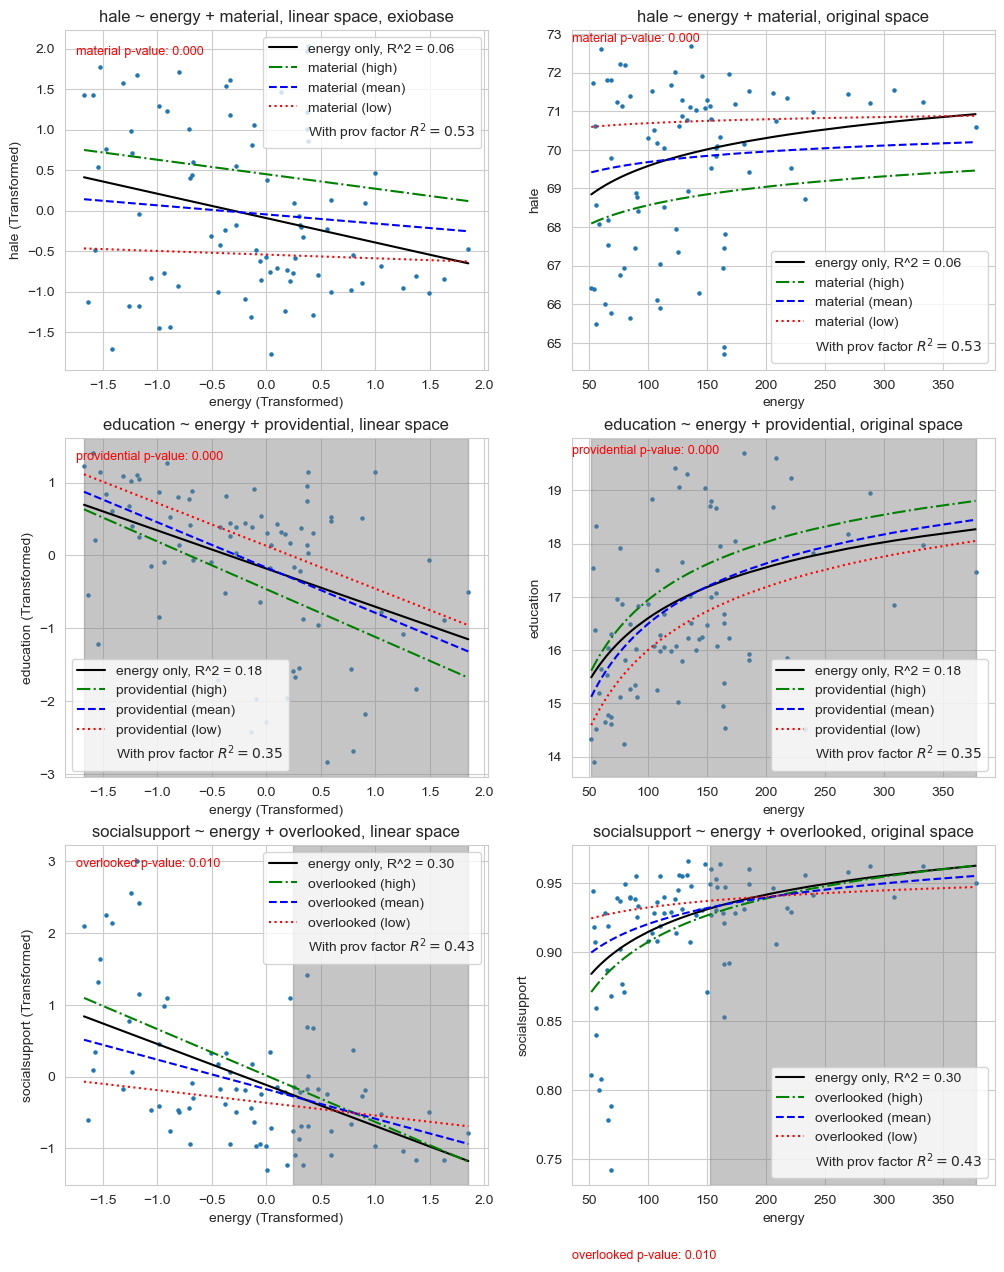

In [238]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))
plot_predictions_on_ax(ax[0, 0], {'energy_only': selected_bivariate_model_exiobase_hale, 'with_provisioning': selected_single_model_exiobase_hale_material}, 'hale', ['energy', 'material'], back_transformed_data_exiobase, foundational_df_transformed_exiobase, scaler_df_exiobase)
plot_predictions_on_ax(ax[0, 1], {'energy_only': selected_bivariate_model_exiobase_hale, 'with_provisioning': selected_single_model_exiobase_hale_material}, 'hale', ['energy', 'material'], back_transformed_data_exiobase, foundational_df_transformed_exiobase, scaler_df_exiobase, back_transform_y=True)
ax[0, 0].set_title(ax[0, 0].get_title() + ", exiobase")
# fig.subplots_adjust(hspace=0.3)  # Increase hspace for more vertical space
plot_predictions_on_ax(ax[1, 0], {'energy_only': selected_bivariate_model_exiobase_education, 'with_provisioning': selected_single_model_exiobase_education_providential}, 'education', ['energy', 'providential'], back_transformed_data_exiobase, foundational_df_transformed_exiobase, scaler_df_exiobase)
plot_predictions_on_ax(ax[1, 1], {'energy_only': selected_bivariate_model_exiobase_education, 'with_provisioning': selected_single_model_exiobase_education_providential}, 'education', ['energy', 'providential'], back_transformed_data_exiobase, foundational_df_transformed_exiobase, scaler_df_exiobase, back_transform_y=True)
plot_predictions_on_ax(ax[2, 0], {'energy_only': selected_bivariate_model_exiobase_socialsupport, 'with_provisioning': selected_single_model_exiobase_socialsupport_overlooked}, 'socialsupport', ['energy', 'overlooked'], back_transformed_data_exiobase, foundational_df_transformed_exiobase, scaler_df_exiobase)
plot_predictions_on_ax(ax[2, 1], {'energy_only': selected_bivariate_model_exiobase_socialsupport, 'with_provisioning': selected_single_model_exiobase_socialsupport_overlooked}, 'socialsupport', ['energy', 'overlooked'], back_transformed_data_exiobase, foundational_df_transformed_exiobase, scaler_df_exiobase, back_transform_y=True)

# IEA Data, all single regressions

## "Hale" outcome variable

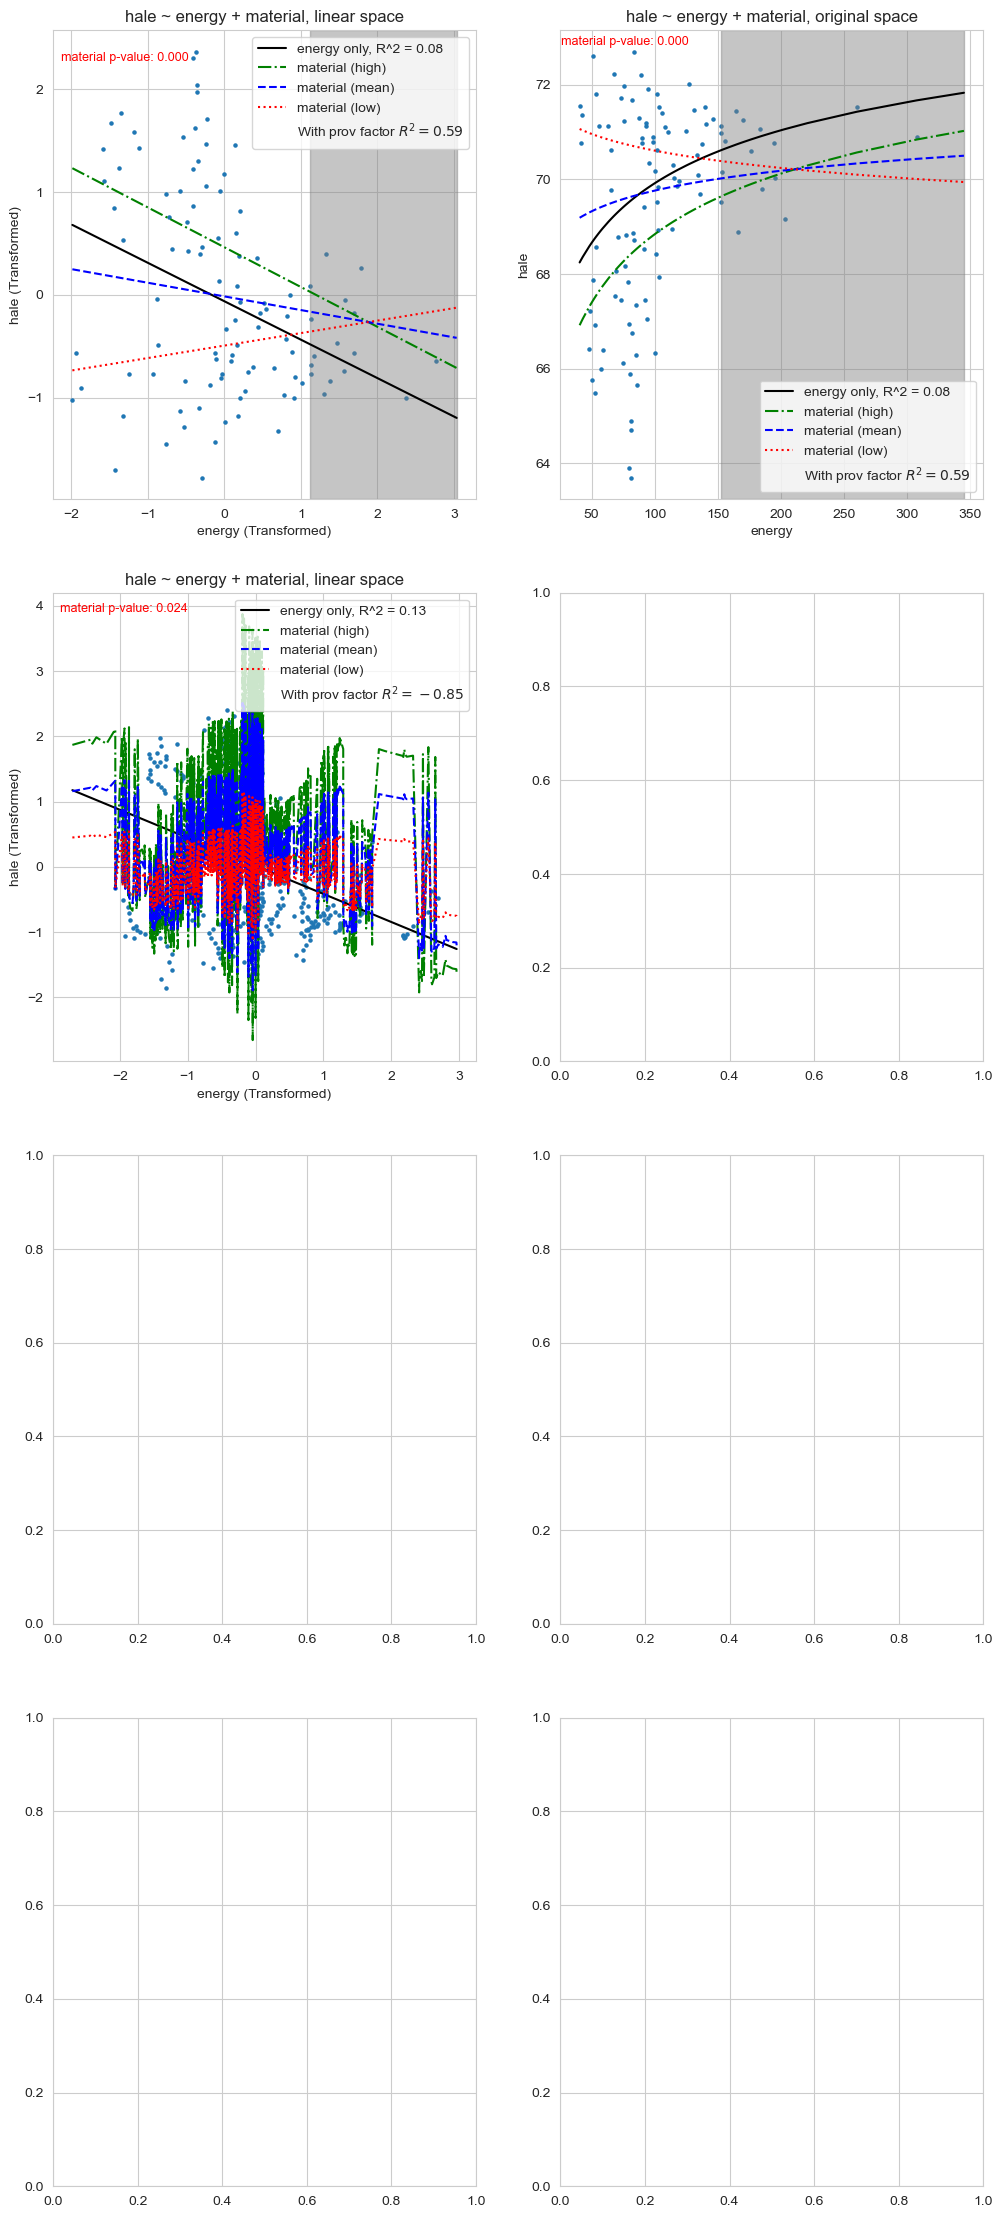

In [239]:
fig, ax = plt.subplots(4, 2, figsize=(12, 28))
plot_predictions_on_ax(ax[0, 0], {'energy_only': selected_bivariate_model_hale, 'with_provisioning': selected_single_model_hale_material}, 'hale', ['energy', 'material'], back_transformed_data, foundational_df_transformed, scaler_df)
plot_predictions_on_ax(ax[0, 1], {'energy_only': selected_bivariate_model_hale, 'with_provisioning': selected_single_model_hale_material}, 'hale', ['energy', 'material'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)
plot_predictions_on_ax(ax[1, 0], {'energy_only': selected_bivariate_model_hale_accounts, 'with_provisioning': selected_single_model_hale_material_accounts}, 'hale', ['energy', 'material'], back_transformed_data_accounts, foundational_df_transformed_accounts, scaler_df_accounts)
# plot_predictions_on_ax(ax[1, 1], {'energy_only': selected_bivariate_model_hale, 'with_provisioning': selected_single_model_hale_material}, 'hale', ['energy', 'material'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)
# plot_predictions_on_ax(ax[1, 0], {'energy_only': selected_bivariate_model_hale, 'with_provisioning': selected_single_model_hale_providential}, 'hale', ['energy', 'providential'], back_transformed_data, foundational_df_transformed, scaler_df)
# plot_predictions_on_ax(ax[1, 1], {'energy_only': selected_bivariate_model_hale, 'with_provisioning': selected_single_model_hale_providential}, 'hale', ['energy', 'providential'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)
# plot_predictions_on_ax(ax[2, 0], {'energy_only': selected_bivariate_model_hale, 'with_provisioning': selected_single_model_hale_overlooked}, 'hale', ['energy', 'overlooked'], back_transformed_data, foundational_df_transformed, scaler_df)
# plot_predictions_on_ax(ax[2, 1], {'energy_only': selected_bivariate_model_hale, 'with_provisioning': selected_single_model_hale_overlooked}, 'hale', ['energy', 'overlooked'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)
# plot_predictions_on_ax(ax[3, 0], {'energy_only': selected_bivariate_model_hale, 'with_provisioning': selected_single_model_hale_other}, 'hale', ['energy', 'other'], back_transformed_data, foundational_df_transformed, scaler_df)
# plot_predictions_on_ax(ax[3, 1], {'energy_only': selected_bivariate_model_hale, 'with_provisioning': selected_single_model_hale_other}, 'hale', ['energy', 'other'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)

In [240]:
# fig, ax = plt.subplots(4, 2, figsize=(12, 28))
# plot_predictions_on_ax(ax[0, 0], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_education_material}, 'education', ['energy', 'material'], back_transformed_data, foundational_df_transformed, scaler_df)
# plot_predictions_on_ax(ax[0, 1], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_education_material}, 'education', ['energy', 'material'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)
# plot_predictions_on_ax(ax[1, 0], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_education_providential}, 'education', ['energy', 'providential'], back_transformed_data, foundational_df_transformed, scaler_df)
# plot_predictions_on_ax(ax[1, 1], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_education_providential}, 'education', ['energy', 'providential'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)
# plot_predictions_on_ax(ax[2, 0], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_education_overlooked}, 'education', ['energy', 'overlooked'], back_transformed_data, foundational_df_transformed, scaler_df)
# plot_predictions_on_ax(ax[2, 1], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_education_overlooked}, 'education', ['energy', 'overlooked'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)
# plot_predictions_on_ax(ax[3, 0], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_education_other}, 'education', ['energy', 'other'], back_transformed_data, foundational_df_transformed, scaler_df)
# plot_predictions_on_ax(ax[3, 1], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_education_other}, 'education', ['energy', 'other'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)

In [241]:
# fig, ax = plt.subplots(4, 2, figsize=(12, 28))
# plot_predictions_on_ax(ax[0, 0], {'energy_only': selected_bivariate_model_socialsupport, 'with_provisioning': selected_single_model_socialsupport_material}, 'socialsupport', ['energy', 'material'], back_transformed_data, foundational_df_transformed, scaler_df)
# plot_predictions_on_ax(ax[0, 1], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_socialsupport_material}, 'socialsupport', ['energy', 'material'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)
# plot_predictions_on_ax(ax[1, 0], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_socialsupport_providential}, 'socialsupport', ['energy', 'providential'], back_transformed_data, foundational_df_transformed, scaler_df)
# plot_predictions_on_ax(ax[1, 1], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_socialsupport_providential}, 'socialsupport', ['energy', 'providential'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)
# plot_predictions_on_ax(ax[2, 0], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_socialsupport_overlooked}, 'socialsupport', ['energy', 'overlooked'], back_transformed_data, foundational_df_transformed, scaler_df)
# plot_predictions_on_ax(ax[2, 1], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_socialsupport_overlooked}, 'socialsupport', ['energy', 'overlooked'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)
# plot_predictions_on_ax(ax[3, 0], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_socialsupport_other}, 'socialsupport', ['energy', 'other'], back_transformed_data, foundational_df_transformed, scaler_df)
# plot_predictions_on_ax(ax[3, 1], {'energy_only': selected_bivariate_model_education, 'with_provisioning': selected_single_model_socialsupport_other}, 'socialsupport', ['energy', 'other'], back_transformed_data, foundational_df_transformed, scaler_df, back_transform_y=True)